In [29]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [30]:
import numpy as np
import pandas as pd

In [31]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [32]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [33]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [34]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [35]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [36]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [37]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [38]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [39]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [40]:
# Get a list of column names and types
columns2 = inspector.get_columns('station')
for c in columns2:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [41]:
from datetime import datetime
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date=datetime.strptime(session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0],'%Y-%m-%d')
# Calculate the date 1 year ago from the last data point in the databas
year_before_last_date = latest_date - dt.timedelta(days=365.25)
print(latest_date)
print(year_before_last_date)

2017-08-23 00:00:00
2016-08-22 18:00:00


In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

results = session.query(Measurement.station,Measurement.prcp,Measurement.date).\
    filter(Measurement.date>=year_before_last_date).filter(Measurement.prcp!="None").\
    order_by(Measurement.date).all()
station=[]
prcp=[]
date=[]
for result in results:
    station.append(result[0])
    prcp.append(result[1])
    date.append(result[2])
    
df=pd.DataFrame({'Date':date,'Station':station,'Precipitation':prcp})
df.head(10)


,Date,Station,Precipitation
0,2016-08-23,USC00519397,0.00
1,2016-08-23,USC00513117,0.15
2,2016-08-23,USC00514830,0.05
3,2016-08-23,USC00519523,0.02
4,2016-08-23,USC00519281,1.79
5,2016-08-23,USC00516128,0.70
6,2016-08-24,USC00519397,0.08
7,2016-08-24,USC00513117,2.15
8,2016-08-24,USC00514830,2.28
9,2016-08-24,USC00519523,1.22


([], <a list of 0 Text xticklabel objects>)

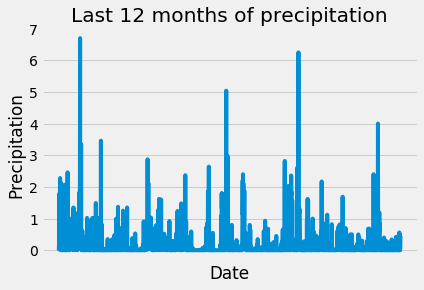

In [43]:
plt.plot(df[['Precipitation']])
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Last 12 months of precipitation')
plt.xticks([])


In [44]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# Design a query to show how many stations are available in this dataset?
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [45]:
# Design a query to show how many stations are available in this dataset?
engine.execute('SELECT count(distinct station) from measurement').fetchall()[0][0]

9

In [46]:
# List the stations and the counts in descending order.
record_count=engine.execute('SELECT distinct station, count(id) from measurement group by station order by count(id) desc').fetchall()
record_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# What are the most active stations? (i.e. what stations have the most rows)?
print(f'The most active station is {record_count[0][0]}')

The most active station is USC00519281


In [48]:
engine.execute('SELECT min(tobs),max(tobs),avg(tobs) from measurement where station="USC00519281"').fetchall()


[(54.0, 85.0, 71.66378066378067)]

In [49]:
# Choose the station with the highest number of temperature observations
engine.execute('SELECT distinct station, count(tobs) from measurement group by station order by count(tobs) desc limit 1').fetchall()

[('USC00519281', 2772)]

In [50]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
records=engine.execute('select * from (SELECT date,tobs from measurement where station = "USC00519281" order by date desc limit 365) order by date').fetchall()
records[0:10]

[('2016-08-10', 82.0),
 ('2016-08-11', 80.0),
 ('2016-08-12', 76.0),
 ('2016-08-13', 80.0),
 ('2016-08-14', 76.0),
 ('2016-08-15', 75.0),
 ('2016-08-16', 74.0),
 ('2016-08-17', 82.0),
 ('2016-08-18', 80.0),
 ('2016-08-19', 79.0)]

In [51]:
date1=[record[0] for record in records]
temperature=pd.DataFrame({'temperature':[record[1] for record in records]})

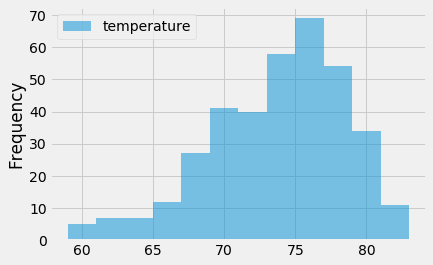

In [52]:
ax = temperature.plot.hist(bins=12, alpha=0.5)

In [65]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates. (Not Sure What This Mean - Duyen)


62.0 68.36585365853658 74.0


In [121]:
# I used 2012-02-28 as my trip start date, a year before would be 2011-02-28

tempt=calc_temps('2011-02-28', '2011-03-05')[0]
tempt

(61.0, 69.75510204081633, 75.0)

Text(0.5, 1.0, 'Trip Avg Tempt')

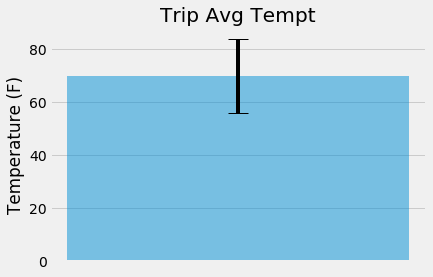

In [122]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
mean_temp=tempt[1]
error=tempt[2]-tempt[0]
x_label = ['temp']
x_pos = np.arange(len(x_label))

fig, ax = plt.subplots()
ax.bar(x_pos, mean_temp, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks([])
ax.set_ylabel('Temperature (F)')
ax.set_title('Trip Avg Tempt')

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


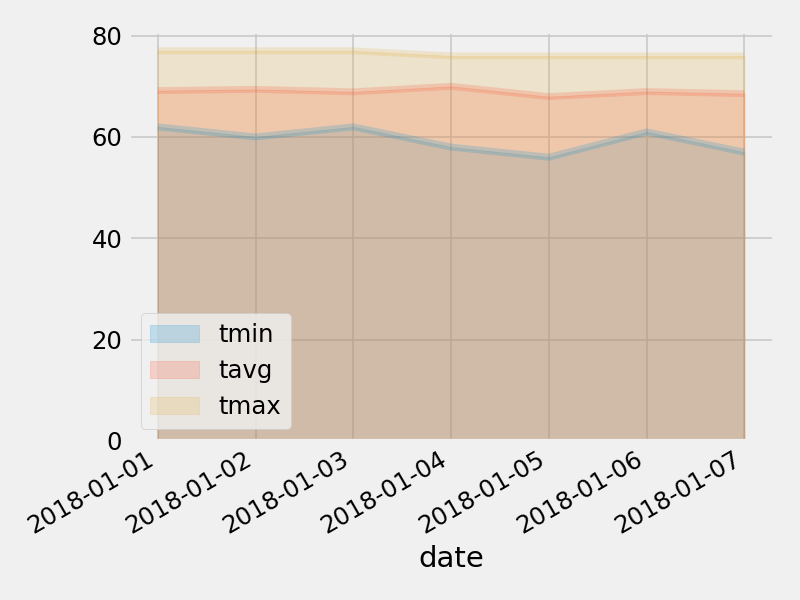

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
